<a href="https://colab.research.google.com/github/123ranika/Research-paper/blob/main/OffensiveLanguageIdentification_BERT_Bangla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Performing checks for the resources available

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [2]:
!pip install transformers

## Importing necessary packages

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [4]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## Importing dataset directories

In [6]:
# from os import getcwd , listdir
# from os.path import join
# curr_dir = getcwd()
# drive_dir = join(curr_dir , 'drive','MyDrive')
# dataset_dir = join(drive_dir,'Codalab','Offensive Language Identification','Dataset')

In [7]:
# listdir(dataset_dir)

## Loading training data

In [8]:
# train_df_path = join(dataset_dir,'tamil_offensive_full_train_corrected.csv')
# Load the dataset into a pandas dataframe.
train_df = pd.read_csv('/content/Traning.xlsx - Sheet1 (7).csv')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 10 random rows from the data.
train_df.sample(10)

Number of training sentences: 6,000



,PID,text,labels
1782,1783,নিচ মানসিকতার ধিক্কার জানাই।,Cyberbullying
3917,3918,খানকির পোলা তোরে আমি খুঁজে বেড়াইতাছি,Cyberbullying
221,222,দাতের ড্রেইন নাকি,Sarcasm
2135,2136,ছেলে তো কালা,Racism
5224,5225,হাসিনা ক্ষমতার লোভে সবকিছু ধ্বংস করে দিল,Political
1168,1169,বেয়াদবের মতো না জেনে শেষের মেয়েটার ভিডিও এড ...,Cyberbullying
879,880,গ্রামের মহিলাদের মতো বাজে মহিলা দেখিনি,Gender_Discrimination
156,157,লিঙ্গবৈষম্য মানে অজ্ঞতার পরিচয়।,Gender_Discrimination
1657,1658,উনার স্বামী এই মুভি দেখে গর্বে গর্ববতী হয়ে গেছে,Cyberbullying
323,324,সীমালংঘনকারীদের আল্লাহ পছন্দ করেন না,Religious_Hatred


In [9]:
train_df['labels'].value_counts()

,count
labels,
Cyberbullying,1686
Sarcasm,1518
Political,776
Gender_Discrimination,678
Religious_Hatred,673
Racism,669


In [10]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [11]:
train_df['labels'].value_counts()

,count
labels,
0,1686
5,1518
2,776
1,678
4,673
3,669


### Loading `train_sentences` and `train_labels`

In [12]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [13]:
class_names = [
                'Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'
]

## Loading the validation data

In [14]:
# val_df_path = join(dataset_dir,'tamil_offensive_full_dev_corrected.csv')
# Load the dataset into a pandas dataframe.
val_df = pd.read_csv('/content/Val.xlsx - Sheet1 (2).csv')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(val_df.shape[0]))

# Display 10 random rows from the data.
val_df.sample(10)

Number of training sentences: 2,000



,PID,text,labels
406,407,তুই একটা শুয়োরের বাচ্চা।,Racism
430,431,শুয়া*ের বাচ্চা তোরা মানুষ না,Cyberbullying
1969,1970,তাদের ধর্ম সমাজে কোনো গরিমা রাখে না।,Religious_Hatred
943,944,কোন মাজার মন্দির উপাসনালয়ে হামলা কাম্য নয় যা...,Religious_Hatred
22,23,আপনাদের এত চুলকানি আগে জানতাম না চুলকাইতে মন চ...,Sarcasm
732,733,দাজ্জালের অনুসারী,Religious_Hatred
1478,1479,কি তোমার কালা পুটকির ঝলক,Cyberbullying
1379,1380,"ভাবির জন্য আলাদা ভিডিও হবে, সেখানে শুধু ভাবির ...",Sarcasm
1148,1149,কালো জাতির মানুষ কোনো উন্নতি করতে পারে না।,Racism
1165,1166,তুমি একটা জেনিস রে ভাই,Sarcasm


In [15]:
val_df['labels'].value_counts()

,count
labels,
Cyberbullying,557
Sarcasm,498
Political,270
Religious_Hatred,236
Racism,222
Gender_Discrimination,217


In [16]:
val_df['labels'] = le.transform(val_df['labels'])

In [17]:
val_df['labels'].value_counts()

,count
labels,
0,557
5,498
2,270
4,236
3,222
1,217


### Loading `val_sentences` and `val_labels`

In [18]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text'].values
val_labels = val_df['labels'].values

## Handling class imbalance using `sklearn's compute_class_weight`



In [19]:

# #compute the class weights
# class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

# print(class_wts)

## Helper Functions

#### 1) Update Interval Function

In [20]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [21]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [22]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [23]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [24]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [25]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [26]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [27]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [28]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [29]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [30]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [31]:
model_name = 'bert-base-multilingual-cased'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading bert-base-multilingual-cased tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [32]:
lengths = []
for text in train_sentences:
    # Check if text is not nan and is a string before calculating length
    if isinstance(text, str) and text == text:  # Check for nan using self-equality
        lengths.append(len(text))
    else:
        # Handle nan or non-string values here, e.g., replace with 0 or skip
        # lengths.append(0)  # Replace with 0
        # or
        print(f"Skipping non-string or NaN value: {text}")  # Print and skip

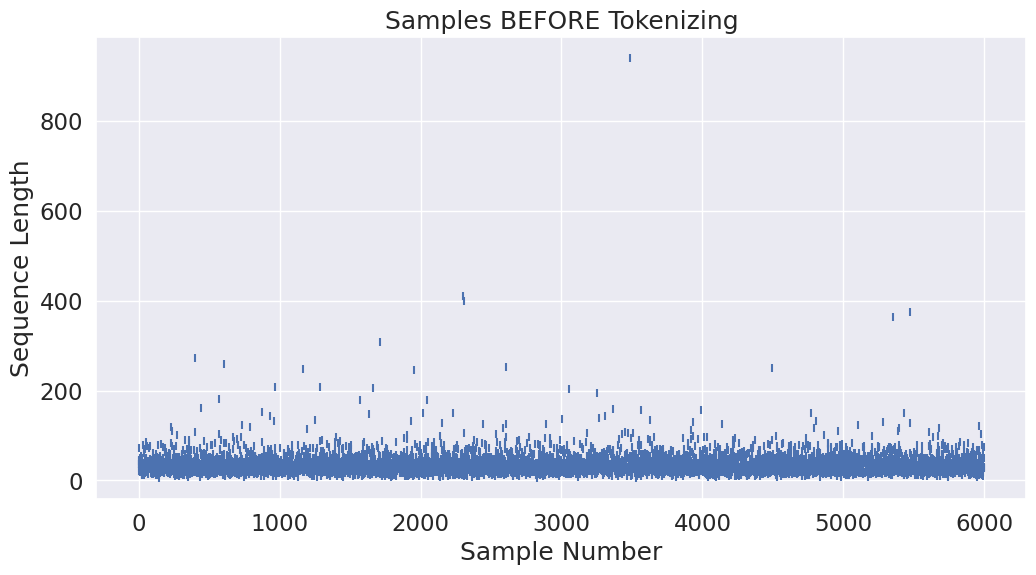

In [33]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [34]:
max_input_length = 400

In [35]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Check if text is a valid string and not nan
    if isinstance(text, str) and text == text:  # Check for nan using self-equality
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sentence.
        input_ids = tokenizer.encode(text=text,
                                     add_special_tokens=True,
                                     max_length=max_input_length,
                                     truncation=True,
                                     padding=False)

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
    else:
        # Handle nan or non-string values, e.g., skip or replace with an empty string
        print(f"Skipping non-string or NaN value: {text}")
        # Alternatively, you can replace nan with an empty string:
        # input_ids = tokenizer.encode(text="", add_special_tokens=True, max_length=max_input_length, truncation=True, padding=False)
        # full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 6,000 training samples...
  Tokenized 0 samples.
  Tokenized 600 samples.
  Tokenized 1,200 samples.
  Tokenized 1,800 samples.
  Tokenized 2,400 samples.
  Tokenized 3,000 samples.
  Tokenized 3,600 samples.
  Tokenized 4,200 samples.
  Tokenized 4,800 samples.
  Tokenized 5,400 samples.
DONE.
     6,000 samples


In [36]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

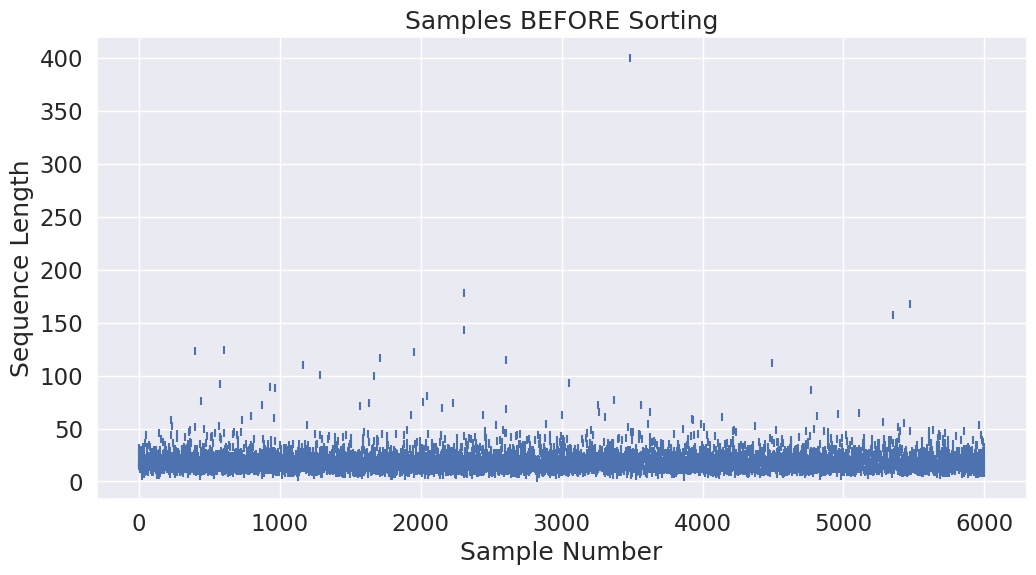

In [37]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [38]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [39]:
train_samples[0:5]

[([101, 100, 102], 0),
 ([101, 102081, 35884, 102], 0),
 ([101, 100, 55816, 102], 3),
 ([101, 100024, 100, 920, 102], 2),
 ([101, 96135, 953, 47719, 102], 0)]

In [40]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 400


In [41]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

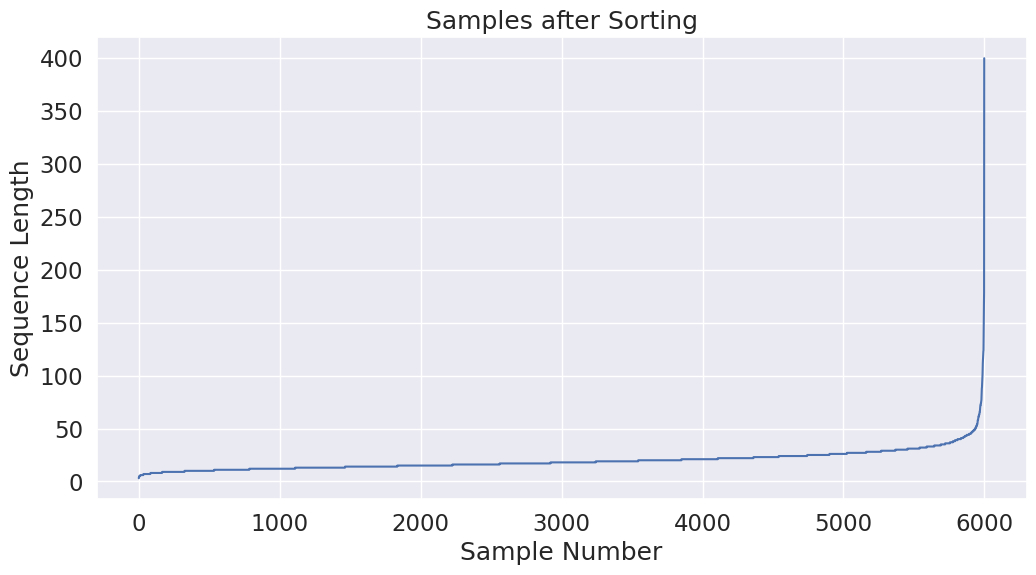

In [42]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [43]:
train_samples[0]

([101, 100, 102], 0)

In [44]:
batch_size = 16

In [45]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.

  DONE - 375 batches.


In [46]:
print(batch_ordered_sentences[0])

[[101, 938, 15258, 28799, 14998, 100024, 978, 64437, 72614, 39315, 18601, 111230, 11199, 938, 11737, 13104, 16431, 15002, 54632, 11128, 33072, 11199, 75247, 969, 62753, 948, 82742, 102], [101, 46085, 11199, 944, 36715, 82937, 136, 82937, 13542, 38833, 55971, 11199, 944, 13458, 944, 136, 46085, 14770, 972, 16166, 42651, 944, 13542, 80317, 82937, 11737, 136, 102], [101, 970, 16166, 111230, 97963, 37855, 938, 22335, 16166, 53883, 960, 78639, 950, 30277, 16431, 970, 11421, 13334, 971, 12235, 38044, 12235, 18262, 17660, 20979, 82937, 11737, 102], [101, 972, 45908, 15215, 16166, 34491, 937, 85005, 74080, 948, 11128, 73242, 970, 16166, 111230, 15613, 968, 15010, 47356, 938, 83924, 15691, 26109, 70295, 26109, 83924, 15691, 102], [101, 14112, 970, 40685, 53883, 100, 944, 13542, 100, 106, 106, 106, 84851, 100, 968, 56173, 11199, 995, 17660, 39427, 111240, 39427, 12079, 119, 119, 119, 119, 102], [101, 978, 12235, 20725, 94792, 18513, 51719, 13334, 958, 18770, 39893, 30806, 951, 13100, 938, 89362,

In [47]:
batch_ordered_labels[0]

[3, 3, 5, 4, 3, 5, 0, 4, 1, 5, 0, 0, 3, 0, 2, 1]

### Padding

In [48]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [49]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 2,400,000
  Smart Batching: 124,784  (94.8% less)


## Load the model configuration from the transformers library using AutoConfig

In [50]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.bert.configuration_bert.BertConfig'> 



In [51]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## Load the model from the transformers library using AutoModel

In [53]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.bert.modeling_bert.BertModel'>


In [54]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [55]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [56]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [57]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [58]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [59]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [60]:
# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = {
    'epoch':[],
    'train_loss':[],
    'Training Time':[],
    'val_loss':[],
    'Validation Time':[],
    'train_acc':[],
    'val_acc':[]
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size,tokenizer,max_input_length)

    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = output.loss
        logits = output.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)

    training_accuracy = check_accuracy(predictions,true_labels)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training Accuracy: {0:.2f}".format(training_accuracy))
    print("  Training epoch took: {:}".format(training_time))

    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)
    val_loss,val_accuracy,validation_time = eval_model(model,py_inputs, py_attn_masks, py_labels)
    # Record all statistics from this epoch.

    print("")
    print("  Average validation loss: {0:.2f}".format(val_loss))
    print("  Validation Accuracy: {0:.2f}".format(val_accuracy))
    print("  Validation epoch took: {:}".format(validation_time))


    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training on 375 batches...
  Batch      40  of      375.    Elapsed: 0:00:06.  Remaining: 0:00:49
  Batch      80  of      375.    Elapsed: 0:00:10.  Remaining: 0:00:38
  Batch     120  of      375.    Elapsed: 0:00:15.  Remaining: 0:00:31
  Batch     160  of      375.    Elapsed: 0:00:19.  Remaining: 0:00:26
  Batch     200  of      375.    Elapsed: 0:00:23.  Remaining: 0:00:21
  Batch     240  of      375.    Elapsed: 0:00:28.  Remaining: 0:00:16
  Batch     280  of      375.    Elapsed: 0:00:32.  Remaining: 0:00:11
  Batch     320  of      375.    Elapsed: 0:00:38.  Remaining: 0:00:07
  Batch     360  of      375.    Elapsed: 0:00:43.  Remaining: 0:00:02

  Average training loss: 1.39
  Training Accuracy: 0.46
  Training epoch took: 0:00:44
Creating Smart Batches from 2,000 examples with batch size 16...

Tokenizing 2,000 samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  Tokenized 400 samples.
  Tokenized 600 samples.
  Tokenized 800 samples

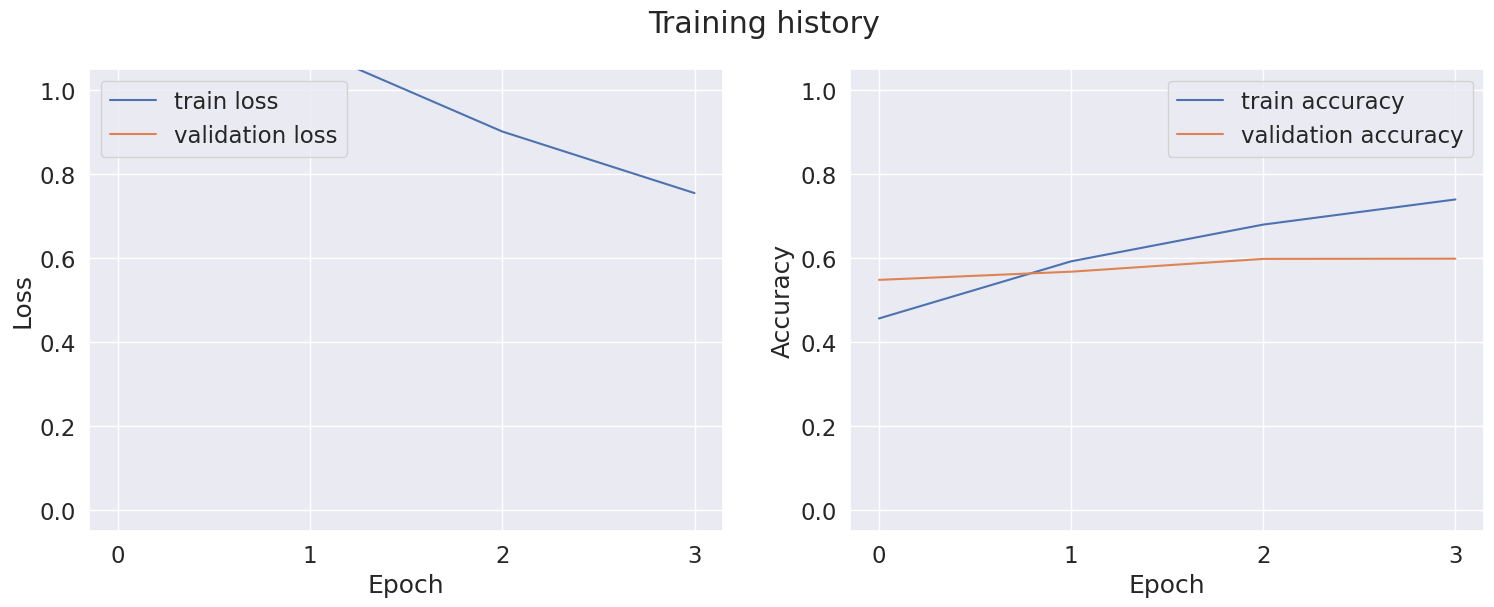

In [61]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [62]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 6,000 examples with batch size 16...

Tokenizing 6,000 samples...
  Tokenized 0 samples.
  Tokenized 600 samples.
  Tokenized 1,200 samples.
  Tokenized 1,800 samples.
  Tokenized 2,400 samples.
  Tokenized 3,000 samples.
  Tokenized 3,600 samples.
  Tokenized 4,200 samples.
  Tokenized 4,800 samples.
  Tokenized 5,400 samples.
DONE.
     6,000 samples

     6,000 samples after sorting

Creating batches of size 16...

  DONE - Selected 375 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 375 test batches...
  Batch      40  of      375.    Elapsed: 0:00:01.  Remaining: 0:00:06
  Batch      80  of      375.    Elapsed: 0:00:02.  Remaining: 0:00:06
  Batch     120  of      375.    Elapsed: 0:00:02.  Remaining: 0:00:05
  Batch     160  of      375.    Elapsed: 0:00:03.  Remaining: 0:00:04
  Batch     200  of      375.    Elapsed: 0:00:04.  Remaining: 0:00:03
  Batch     240  of      375.    Elapsed: 0:00:05.  Remaining: 0:00:03

In [63]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

        Cyberbullying       0.77      0.78      0.78      1686
     Religious_Hatred       0.82      0.65      0.72       678
Gender_Discrimination       0.90      0.87      0.88       776
              Sarcasm       0.79      0.75      0.77       669
            Political       0.90      0.87      0.89       673
               Racism       0.77      0.87      0.82      1518

             accuracy                           0.81      6000
            macro avg       0.82      0.80      0.81      6000
         weighted avg       0.81      0.81      0.81      6000



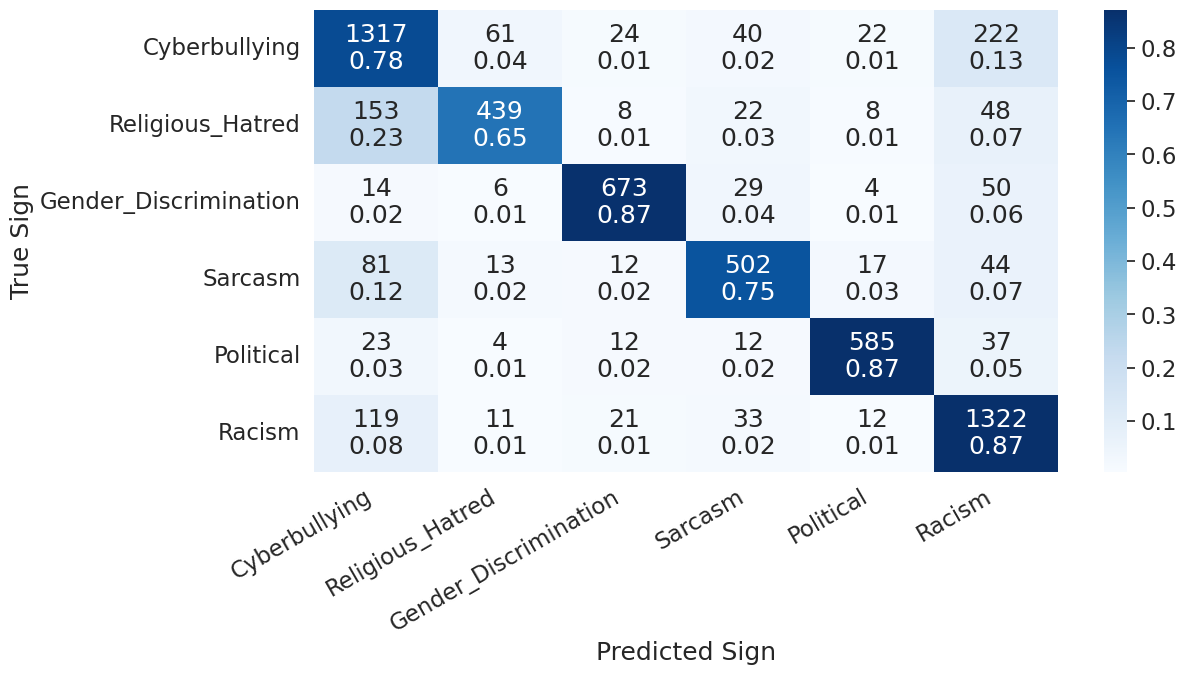

In [64]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [65]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 2,000 examples with batch size 16...

Tokenizing 2,000 samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  Tokenized 400 samples.
  Tokenized 600 samples.
  Tokenized 800 samples.
  Tokenized 1,000 samples.
  Tokenized 1,200 samples.
  Tokenized 1,400 samples.
  Tokenized 1,600 samples.
  Tokenized 1,800 samples.
DONE.
     2,000 samples

     2,000 samples after sorting

Creating batches of size 16...

  DONE - Selected 125 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 125 test batches...
  Batch      10  of      125.    Elapsed: 0:00:00.  Remaining: 0:00:02
  Batch      20  of      125.    Elapsed: 0:00:00.  Remaining: 0:00:02
  Batch      30  of      125.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      40  of      125.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      50  of      125.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      60  of      125.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Bat

In [66]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

        Cyberbullying       0.53      0.56      0.55       557
     Religious_Hatred       0.66      0.48      0.56       217
Gender_Discrimination       0.73      0.70      0.72       270
              Sarcasm       0.54      0.54      0.54       222
            Political       0.77      0.72      0.75       236
               Racism       0.55      0.61      0.57       498

             accuracy                           0.60      2000
            macro avg       0.63      0.60      0.61      2000
         weighted avg       0.61      0.60      0.60      2000



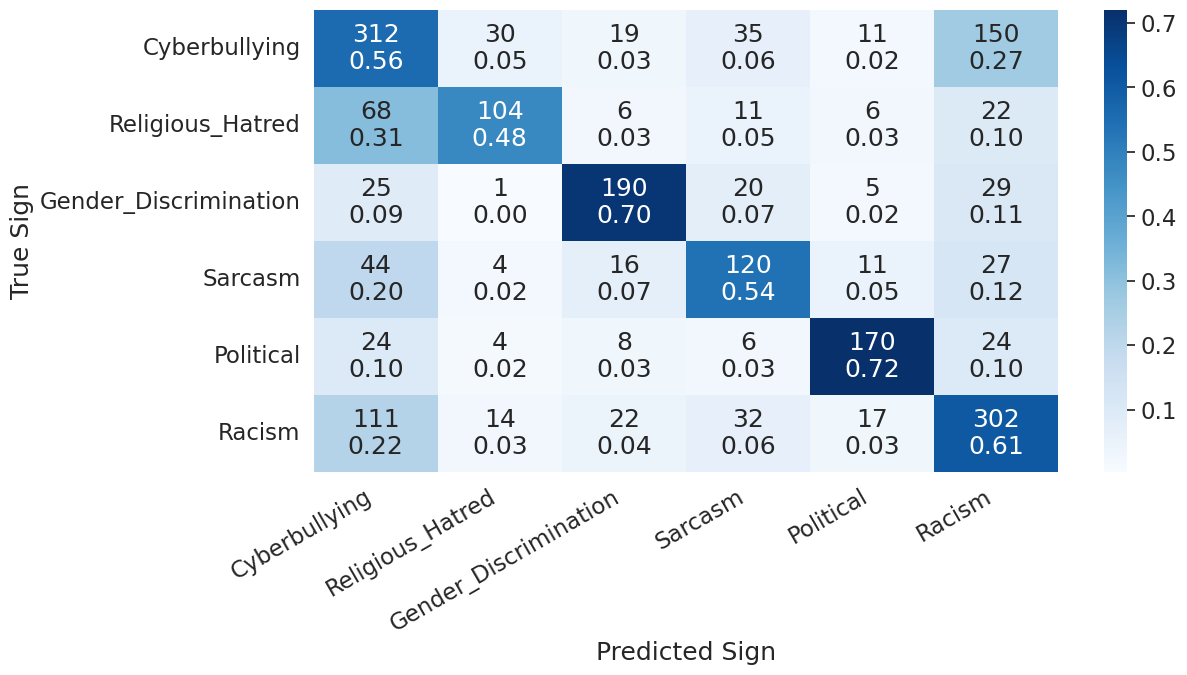

In [67]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [68]:

test_df = pd.read_csv('/content/Test.xlsx - Sheet1 (2).csv')

In [69]:
test_df

,PID,text,labels
0,1,আপনি আমার বাড়িতে এসে রেষ্ট করেতো পারতেন,Sarcasm
1,2,আহারে পাত্রী পাওয়া যাচ্ছে না,Gender_Discrimination
2,3,দুই ধর্মের দুইজন মানুষ এখানে নাচলো আর তাতেই শু...,Religious_Hatred
3,4,চেহারাটা মাশাআল্লাহ ফুটফুটে সুন্দর,Sarcasm
4,5,তুমহারা গান্ড মে দম হে সামাজগিয়া।,Sarcasm
...,...,...,...
1995,1996,"নারীদের অবহেলা করলে, তা তোমার ভবিষ্যতের অবমাননা।",Gender_Discrimination
1996,1997,কি দেখমু আর,Sarcasm
1997,1998,"তোদের ধর্মে কিছুই নেই, সব নোংরা।",Religious_Hatred
1998,1999,কাপড় টা খুলে রাখলেই তো হয়,Cyberbullying


## Loading `test_sentences`

In [70]:
test_sentences = test_df['text'].values

In [71]:
# max_input_length=128
# (py_inputs, py_attn_masks) = make_smart_batches_on_test(test_sentences, batch_size,tokenizer)

## Evaluating accuracy over test set

In [72]:
# y_pred  = get_predictions_test(py_inputs, py_attn_masks)


In [73]:
print(y_pred)

[5 0 0 ... 2 2 2]


In [74]:
le.inverse_transform(y_pred)

array(['Sarcasm', 'Cyberbullying', 'Cyberbullying', ..., 'Political',
       'Political', 'Political'], dtype=object)

<Axes: xlabel='count'>

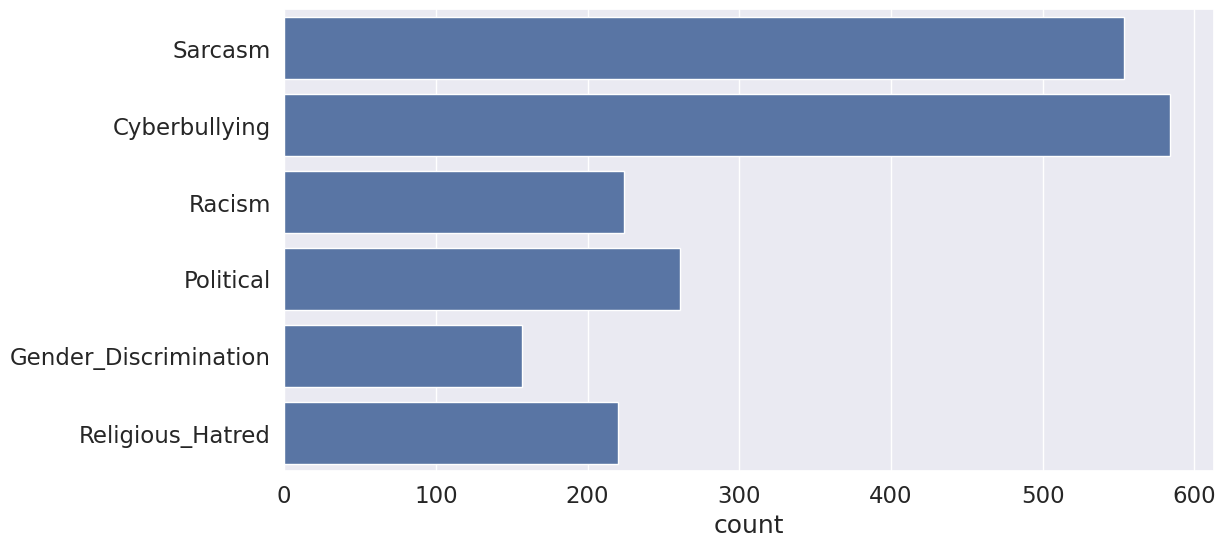

In [75]:
sns.countplot(y =le.inverse_transform(y_pred))

## Saving the model

In [76]:
#torch.save(model,"./drive/MyDrive/Codalab/Offensive Language Identification/Models/BERTForSequenceClassification_Multilingual_Tamil_v1")

## Loading the model

In [77]:
#model = torch.load('./drive/MyDrive/Codalab/Offensive Language Identification/Models/BERTForSequenceClassification_Multilingual_Tamil_v1',map_location=device)

In [78]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## Making Predictions on Test Set

In [79]:
# test_df_path = join(dataset_dir,'tamil_offensive_full_test.csv')
test_df = pd.read_csv('/content/Test.xlsx - Sheet1 (2).csv')

In [80]:
test_df

,PID,text,labels
0,1,আপনি আমার বাড়িতে এসে রেষ্ট করেতো পারতেন,Sarcasm
1,2,আহারে পাত্রী পাওয়া যাচ্ছে না,Gender_Discrimination
2,3,দুই ধর্মের দুইজন মানুষ এখানে নাচলো আর তাতেই শু...,Religious_Hatred
3,4,চেহারাটা মাশাআল্লাহ ফুটফুটে সুন্দর,Sarcasm
4,5,তুমহারা গান্ড মে দম হে সামাজগিয়া।,Sarcasm
...,...,...,...
1995,1996,"নারীদের অবহেলা করলে, তা তোমার ভবিষ্যতের অবমাননা।",Gender_Discrimination
1996,1997,কি দেখমু আর,Sarcasm
1997,1998,"তোদের ধর্মে কিছুই নেই, সব নোংরা।",Religious_Hatred
1998,1999,কাপড় টা খুলে রাখলেই তো হয়,Cyberbullying


## Loading `test_sentences`

In [81]:
test_sentences = test_df['text'].values
test_ids = test_df.index.values

In [82]:
test_ids

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [83]:
test_sentences

array(['আপনি আমার বাড়িতে এসে রেষ্ট করেতো পারতেন',
       'আহারে পাত্রী পাওয়া যাচ্ছে না',
       'দুই ধর্মের দুইজন মানুষ এখানে নাচলো আর তাতেই শুরু হয়ে গেল কুরুচিপূর্ণ চিন্তাভাবনা,',
       ..., 'তোদের ধর্মে কিছুই নেই, সব নোংরা।',
       'কাপড় টা খুলে রাখলেই তো হয়', 'কাম সাইরা ফালাইছেন ভাই'],
      dtype=object)

In [84]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 2,000 examples with batch size 16...

Tokenizing 2,000 samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  Tokenized 400 samples.
  Tokenized 600 samples.
  Tokenized 800 samples.
  Tokenized 1,000 samples.
  Tokenized 1,200 samples.
  Tokenized 1,400 samples.
  Tokenized 1,600 samples.
  Tokenized 1,800 samples.
DONE.
     2,000 samples

     2,000 samples after sorting

Creating batches of size 16...

  DONE - Selected 125 batches.

Padding out sequences within each batch...
  DONE.


## Evaluating accuracy over test set

In [85]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 125 test batches...
  Batch      10  of      125.    Elapsed: 0:00:00.  Remaining: 0:00:03
  Batch      20  of      125.    Elapsed: 0:00:00.  Remaining: 0:00:02
  Batch      30  of      125.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      40  of      125.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      50  of      125.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      60  of      125.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      70  of      125.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      80  of      125.    Elapsed: 0:00:02.  Remaining: 0:00:01
  Batch      90  of      125.    Elapsed: 0:00:02.  Remaining: 0:00:01
  Batch     100  of      125.    Elapsed: 0:00:02.  Remaining: 0:00:00
  Batch     110  of      125.    Elapsed: 0:00:02.  Remaining: 0:00:00
  Batch     120  of      125.    Elapsed: 0:00:02.  Remaining: 0:00:00


In [86]:
print(y_preds)

[0 5 3 ... 5 3 2]


In [87]:
print(y_ids)

[1938 1942 1958 ...  365  385 1727]


In [88]:
le.inverse_transform(y_preds)

array(['Cyberbullying', 'Sarcasm', 'Racism', ..., 'Sarcasm', 'Racism',
       'Political'], dtype=object)

<Axes: xlabel='count'>

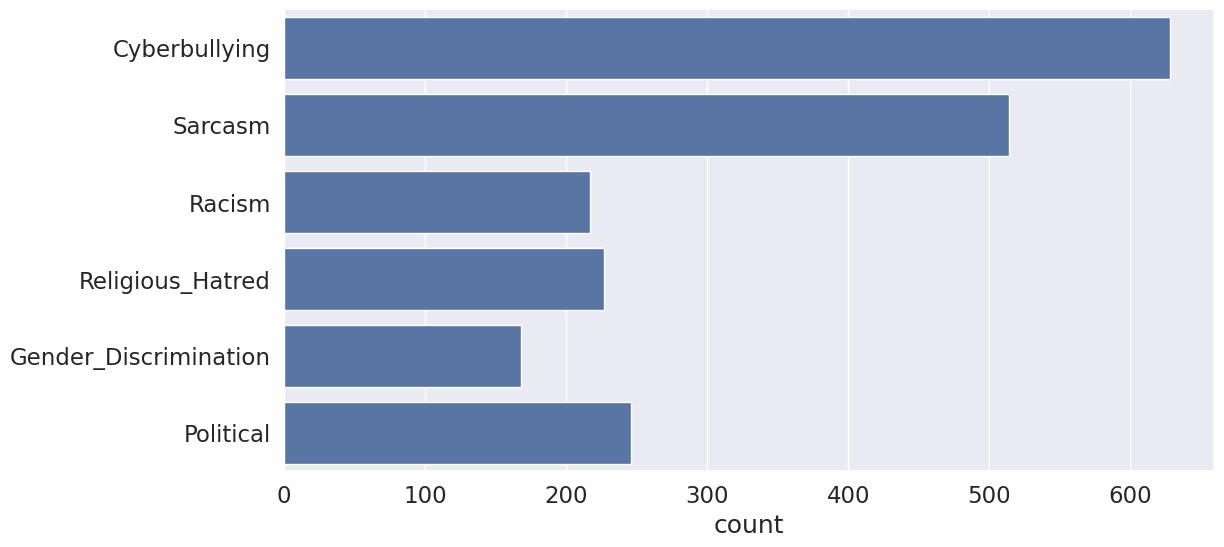

In [89]:
sns.countplot(y =le.inverse_transform(y_preds))

In [90]:
len(y_ids)

2000

In [91]:
len(le.inverse_transform(y_preds))

2000

## Creating Submission DataFrame

In [92]:


df_new = pd.DataFrame({
    'id':y_ids,
    'labels':le.inverse_transform(y_preds)
})

In [93]:

test_df['id'] = test_df.index

In [94]:
df_new

,id,labels
0,1938,Cyberbullying
1,1942,Sarcasm
2,1958,Racism
3,1975,Cyberbullying
4,1977,Sarcasm
...,...,...
1995,887,Sarcasm
1996,910,Cyberbullying
1997,365,Sarcasm
1998,385,Racism


In [95]:
test_df

,PID,text,labels,id
0,1,আপনি আমার বাড়িতে এসে রেষ্ট করেতো পারতেন,Sarcasm,0
1,2,আহারে পাত্রী পাওয়া যাচ্ছে না,Gender_Discrimination,1
2,3,দুই ধর্মের দুইজন মানুষ এখানে নাচলো আর তাতেই শু...,Religious_Hatred,2
3,4,চেহারাটা মাশাআল্লাহ ফুটফুটে সুন্দর,Sarcasm,3
4,5,তুমহারা গান্ড মে দম হে সামাজগিয়া।,Sarcasm,4
...,...,...,...,...
1995,1996,"নারীদের অবহেলা করলে, তা তোমার ভবিষ্যতের অবমাননা।",Gender_Discrimination,1995
1996,1997,কি দেখমু আর,Sarcasm,1996
1997,1998,"তোদের ধর্মে কিছুই নেই, সব নোংরা।",Religious_Hatred,1997
1998,1999,কাপড় টা খুলে রাখলেই তো হয়,Cyberbullying,1998


In [96]:
df_f = pd.merge(test_df,df_new,on = 'id')
df_f

,PID,text,labels_x,id,labels_y
0,1,আপনি আমার বাড়িতে এসে রেষ্ট করেতো পারতেন,Sarcasm,0,Sarcasm
1,2,আহারে পাত্রী পাওয়া যাচ্ছে না,Gender_Discrimination,1,Cyberbullying
2,3,দুই ধর্মের দুইজন মানুষ এখানে নাচলো আর তাতেই শু...,Religious_Hatred,2,Religious_Hatred
3,4,চেহারাটা মাশাআল্লাহ ফুটফুটে সুন্দর,Sarcasm,3,Cyberbullying
4,5,তুমহারা গান্ড মে দম হে সামাজগিয়া।,Sarcasm,4,Sarcasm
...,...,...,...,...,...
1995,1996,"নারীদের অবহেলা করলে, তা তোমার ভবিষ্যতের অবমাননা।",Gender_Discrimination,1995,Gender_Discrimination
1996,1997,কি দেখমু আর,Sarcasm,1996,Sarcasm
1997,1998,"তোদের ধর্মে কিছুই নেই, সব নোংরা।",Religious_Hatred,1997,Religious_Hatred
1998,1999,কাপড় টা খুলে রাখলেই তো হয়,Cyberbullying,1998,Sarcasm


In [97]:
#df_f = df_f[['PID','label']]


## Saving Submission DataFrame

In [98]:
path = '/content/drive/MyDriveShared Tasl'

In [99]:
df_f.to_csv(join(path,'submissin1.csv'),index=False)

NameError: name 'join' is not defined